# Single-cell RNA Sequencing of human scalp: Analysis

Data Source Acknowledgment: The dataset is sourced from [GSE212450](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE212450). This notebook uses sub-dataset which comprises single-cell RNA sequencing data from human scalp with alopecia areata (GSM6532922	AA8_scRNA) and control (GSM6532927	C_SD2_scRNA).

Reference: Ober-Reynolds B, Wang C, Ko JM, Rios EJ et al. Integrated single-cell chromatin and transcriptomic analyses of human scalp identify gene-regulatory programs and critical cell types for hair and skin diseases. Nat Genet 2023 Aug;55(8):1288-1300. PMID: 37500727

It's essential to emphasize that this dataset is exclusively utilized for Python practice purposes within this repository. This notebook will use this dataset to practice data cleaning techniques and clustering.

In [1]:
#using SCanalysis environment
import numpy as np
import pandas as pd
import seaborn as  sns
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import anndata as ad

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

In [21]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=160,
    facecolor="white",
    frameon=False,)

In [4]:
adata = sc.read_h5ad('annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

## 1. Total proportion in each sample

Calculate the frequency of each cell types in case and control group

In [5]:
total_cells = adata.obs.groupby(['sample']).count()
total_cells

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,doublet,celltypist_skin_label,celltypist_conf_score,_scvi_batch,_scvi_labels,overcluster,celltypist_skin_major,manual_label
sample,,,,,,,,,,,,,,,,
case,4809,4809,4809,4809,4809,4809,4809,4809,4809,4809,4809,4809,4809,4809,4809,4809
control,1890,1890,1890,1890,1890,1890,1890,1890,1890,1890,1890,1890,1890,1890,1890,1890


In [6]:
total_cells = dict(zip(total_cells.index, total_cells.doublet))

In [7]:
total_cells

{'case': 4809, 'control': 1890}

In [8]:
cell_type_count = adata.obs.groupby(['sample', 'manual_label']).count()

In [9]:
cell_type_count

n_genes_by_counts  log1p_n_genes_by_counts  \
sample  manual_label                                                        
case    CD4+T                               1821                     1821   
        CD8+T                                751                      751   
        HFDPC                                 52                       52   
        HF_keratinocyte                       12                       12   
        M1_macrophage                         29                       29   
        Treg                                 391                      391   
        basal_keratinocyte                   115                      115   
        dendritic_cell                       145                      145   
        dermal_fibroblast                    332                      332   
        dermal_sheath                        127                      127   
        lymphatic_endothelium                 40                       40   
        macrophage                           164                      164   
        mast_cell                             75                       75   
        melanocyte                            70                       70   
        myocyte                              261                      261   
        pericyte                              58                       58   
        plasma_cell                           54                       54   
        spinous_keratinocyte                 116                      116   
        vascular_endothelium                 196                      196   
control CD4+T                                108                      108   
        CD8+T                                 42                       42   
        HFDPC                                 54                       54   
        HF_keratinocyte                       73                       73   
        M1_macrophage                         12                       12   
        Treg                                  40                       40   
        basal_keratinocyte                    38                       38   
        dendritic_cell                        84                       84   
        dermal_fibroblast                    420                      420   
        dermal_sheath                         24                       24   
        lymphatic_endothelium                 16                       16   
        macrophage                           194                      194   
        mast_cell                            183                      183   
        melanocyte                            49                       49   
        myocyte                              106                      106   
        pericyte                              39                       39   
        plasma_cell                            3                        3   
        spinous_keratinocyte                 282                      282   
        vascular_endothelium                 123                      123   

                               total_counts  log1p_total_counts  \
sample  manual_label                                              
case    CD4+T                          1821                1821   
        CD8+T                           751                 751   
        HFDPC                            52                  52   
        HF_keratinocyte                  12                  12   
        M1_macrophage                    29                  29   
        Treg                            391                 391   
        basal_keratinocyte              115                 115   
        dendritic_cell                  145                 145   
        dermal_fibroblast               332                 332   
        dermal_sheath                   127                 127   
        lymphatic_endothelium            40                  40   
        macrophage                      164                 164   
        mast

In [10]:
#get rid of row with 0 and break these 2 index down into only 1 index
cell_type_count = cell_type_count[cell_type_count.sum(axis = 1) > 0].reset_index()
cell_type_count

,sample,manual_label,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,doublet,celltypist_skin_label,celltypist_conf_score,_scvi_batch,_scvi_labels,overcluster,celltypist_skin_major
0,case,CD4+T,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821
1,case,CD8+T,751,751,751,751,751,751,751,751,751,751,751,751,751,751,751
2,case,HFDPC,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
3,case,HF_keratinocyte,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
4,case,M1_macrophage,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
5,case,Treg,391,391,391,391,391,391,391,391,391,391,391,391,391,391,391
6,case,basal_keratinocyte,115,115,115,115,115,115,115,115,115,115,115,115,115,115,115
7,case,dendritic_cell,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145
8,case,dermal_fibroblast,332,332,332,332,332,332,332,332,332,332,332,332,332,332,332
9,case,dermal_sheath,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127


In [11]:
cell_type_count = cell_type_count[['sample', 'manual_label', 'doublet']]
cell_type_count

,sample,manual_label,doublet
0,case,CD4+T,1821
1,case,CD8+T,751
2,case,HFDPC,52
3,case,HF_keratinocyte,12
4,case,M1_macrophage,29
5,case,Treg,391
6,case,basal_keratinocyte,115
7,case,dendritic_cell,145
8,case,dermal_fibroblast,332
9,case,dermal_sheath,127


In [12]:
#add total cell of each sample in the new column
cell_type_count['total_cells'] = cell_type_count['sample'].map(total_cells)
cell_type_count

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/781081177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['total_cells'] = cell_type_count['sample'].map(total_cells)


,sample,manual_label,doublet,total_cells
0,case,CD4+T,1821,4809
1,case,CD8+T,751,4809
2,case,HFDPC,52,4809
3,case,HF_keratinocyte,12,4809
4,case,M1_macrophage,29,4809
5,case,Treg,391,4809
6,case,basal_keratinocyte,115,4809
7,case,dendritic_cell,145,4809
8,case,dermal_fibroblast,332,4809
9,case,dermal_sheath,127,4809


In [13]:
cell_type_count.dtypes

sample          category
manual_label    category
doublet            int64
total_cells     category
dtype: object

In [14]:
cell_type_count['total_cells'] = cell_type_count['total_cells'].astype(int)
cell_type_count['frequency'] = cell_type_count.doublet / cell_type_count.total_cells
cell_type_count

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/4273496426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['total_cells'] = cell_type_count['total_cells'].astype(int)
/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/4273496426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['frequency'] = cell_type_count.doublet / cell_type_count.total_cells


,sample,manual_label,doublet,total_cells,frequency
0,case,CD4+T,1821,4809,0.378665
1,case,CD8+T,751,4809,0.156166
2,case,HFDPC,52,4809,0.010813
3,case,HF_keratinocyte,12,4809,0.002495
4,case,M1_macrophage,29,4809,0.006030
5,case,Treg,391,4809,0.081306
6,case,basal_keratinocyte,115,4809,0.023913
7,case,dendritic_cell,145,4809,0.030152
8,case,dermal_fibroblast,332,4809,0.069037
9,case,dermal_sheath,127,4809,0.026409


In [15]:
#create stack bar plot of each samples

cell_types = cell_type_count['manual_label'].unique() #get unique cell type
df_grouped = cell_type_count.groupby(['sample', 'manual_label'])['frequency'].sum().unstack()
df_grouped = df_grouped.reset_index()
df_grouped

manual_label,sample,CD4+T,CD8+T,HFDPC,HF_keratinocyte,M1_macrophage,Treg,basal_keratinocyte,dendritic_cell,dermal_fibroblast,dermal_sheath,lymphatic_endothelium,macrophage,mast_cell,melanocyte,myocyte,pericyte,plasma_cell,spinous_keratinocyte,vascular_endothelium
0,case,0.378665,0.156166,0.010813,0.002495,0.006030,0.081306,0.023913,0.030152,0.069037,0.026409,0.008318,0.034103,0.015596,0.014556,0.054273,0.012061,0.011229,0.024121,0.040757
1,control,0.057143,0.022222,0.028571,0.038624,0.006349,0.021164,0.020106,0.044444,0.222222,0.012698,0.008466,0.102646,0.096825,0.025926,0.056085,0.020635,0.001587,0.149206,0.065079


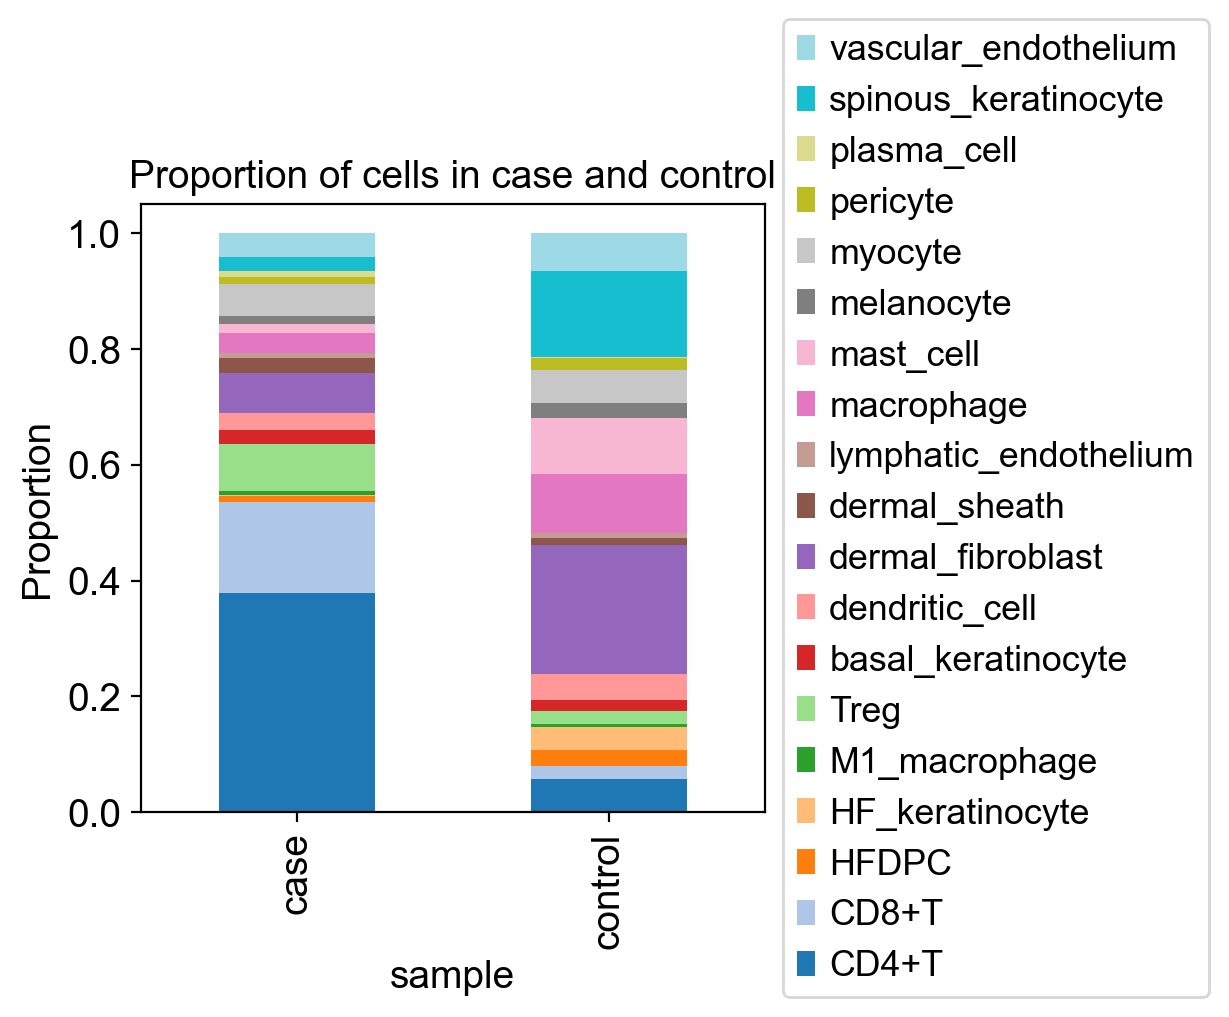

In [16]:
ax = df_grouped.plot(x='sample', kind='bar', stacked=True, colormap='tab20')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
plt.ylabel('Proportion')
plt.title('Proportion of cells in case and control')
# Remove grid lines
ax.grid(False)
plt.show()

In [17]:
cell_type_count_eachType = adata.obs.groupby(['manual_label']).count()

In [18]:
cell_type_count_eachType

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,doublet,sample,celltypist_skin_label,celltypist_conf_score,_scvi_batch,_scvi_labels,overcluster,celltypist_skin_major
manual_label,,,,,,,,,,,,,,,,
CD4+T,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929
CD8+T,793,793,793,793,793,793,793,793,793,793,793,793,793,793,793,793
HFDPC,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106
HF_keratinocyte,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85
M1_macrophage,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41
Treg,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431
basal_keratinocyte,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153
dendritic_cell,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229
dermal_fibroblast,752,752,752,752,752,752,752,752,752,752,752,752,752,752,752,752


In [19]:
total_cell_eachType = dict(zip(cell_type_count_eachType.index, cell_type_count_eachType.doublet))

In [20]:
total_cell_eachType 

{'CD4+T': 1929,
 'CD8+T': 793,
 'HFDPC': 106,
 'HF_keratinocyte': 85,
 'M1_macrophage': 41,
 'Treg': 431,
 'basal_keratinocyte': 153,
 'dendritic_cell': 229,
 'dermal_fibroblast': 752,
 'dermal_sheath': 151,
 'lymphatic_endothelium': 56,
 'macrophage': 358,
 'mast_cell': 258,
 'melanocyte': 119,
 'myocyte': 367,
 'pericyte': 97,
 'plasma_cell': 57,
 'spinous_keratinocyte': 398,
 'vascular_endothelium': 319}

In [21]:
cell_type_count['total_cells_eachType'] = cell_type_count['manual_label'].map(total_cell_eachType)

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/3510994949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['total_cells_eachType'] = cell_type_count['manual_label'].map(total_cell_eachType)


In [22]:
cell_type_count

,sample,manual_label,doublet,total_cells,frequency,total_cells_eachType
0,case,CD4+T,1821,4809,0.378665,1929
1,case,CD8+T,751,4809,0.156166,793
2,case,HFDPC,52,4809,0.010813,106
3,case,HF_keratinocyte,12,4809,0.002495,85
4,case,M1_macrophage,29,4809,0.006030,41
5,case,Treg,391,4809,0.081306,431
6,case,basal_keratinocyte,115,4809,0.023913,153
7,case,dendritic_cell,145,4809,0.030152,229
8,case,dermal_fibroblast,332,4809,0.069037,752
9,case,dermal_sheath,127,4809,0.026409,151


In [23]:
cell_type_count.dtypes

sample                  category
manual_label            category
doublet                    int64
total_cells                int64
frequency                float64
total_cells_eachType    category
dtype: object

In [24]:
cell_type_count['total_cells_eachType'] = cell_type_count['total_cells_eachType'].astype(int)
cell_type_count['frequency_eachType'] = cell_type_count.doublet / cell_type_count.total_cells_eachType
cell_type_count

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/890378272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['total_cells_eachType'] = cell_type_count['total_cells_eachType'].astype(int)
/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/890378272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['frequency_eachType'] = cell_type_count.doublet / cell_type_count.total_cells_eachType


,sample,manual_label,doublet,total_cells,frequency,total_cells_eachType,frequency_eachType
0,case,CD4+T,1821,4809,0.378665,1929,0.944012
1,case,CD8+T,751,4809,0.156166,793,0.947037
2,case,HFDPC,52,4809,0.010813,106,0.490566
3,case,HF_keratinocyte,12,4809,0.002495,85,0.141176
4,case,M1_macrophage,29,4809,0.006030,41,0.707317
5,case,Treg,391,4809,0.081306,431,0.907193
6,case,basal_keratinocyte,115,4809,0.023913,153,0.751634
7,case,dendritic_cell,145,4809,0.030152,229,0.633188
8,case,dermal_fibroblast,332,4809,0.069037,752,0.441489
9,case,dermal_sheath,127,4809,0.026409,151,0.841060


In [25]:
#create stack bar plot of each samples
cell_types = cell_type_count['manual_label'].unique()
df_grouped = cell_type_count.groupby(['sample', 'manual_label'])['frequency_eachType'].sum().unstack()
df_grouped = df_grouped.T
df_grouped

sample,case,control
manual_label,,
CD4+T,0.944012,0.055988
CD8+T,0.947037,0.052963
HFDPC,0.490566,0.509434
HF_keratinocyte,0.141176,0.858824
M1_macrophage,0.707317,0.292683
Treg,0.907193,0.092807
basal_keratinocyte,0.751634,0.248366
dendritic_cell,0.633188,0.366812
dermal_fibroblast,0.441489,0.558511


In [26]:
df_grouped = df_grouped.reset_index()

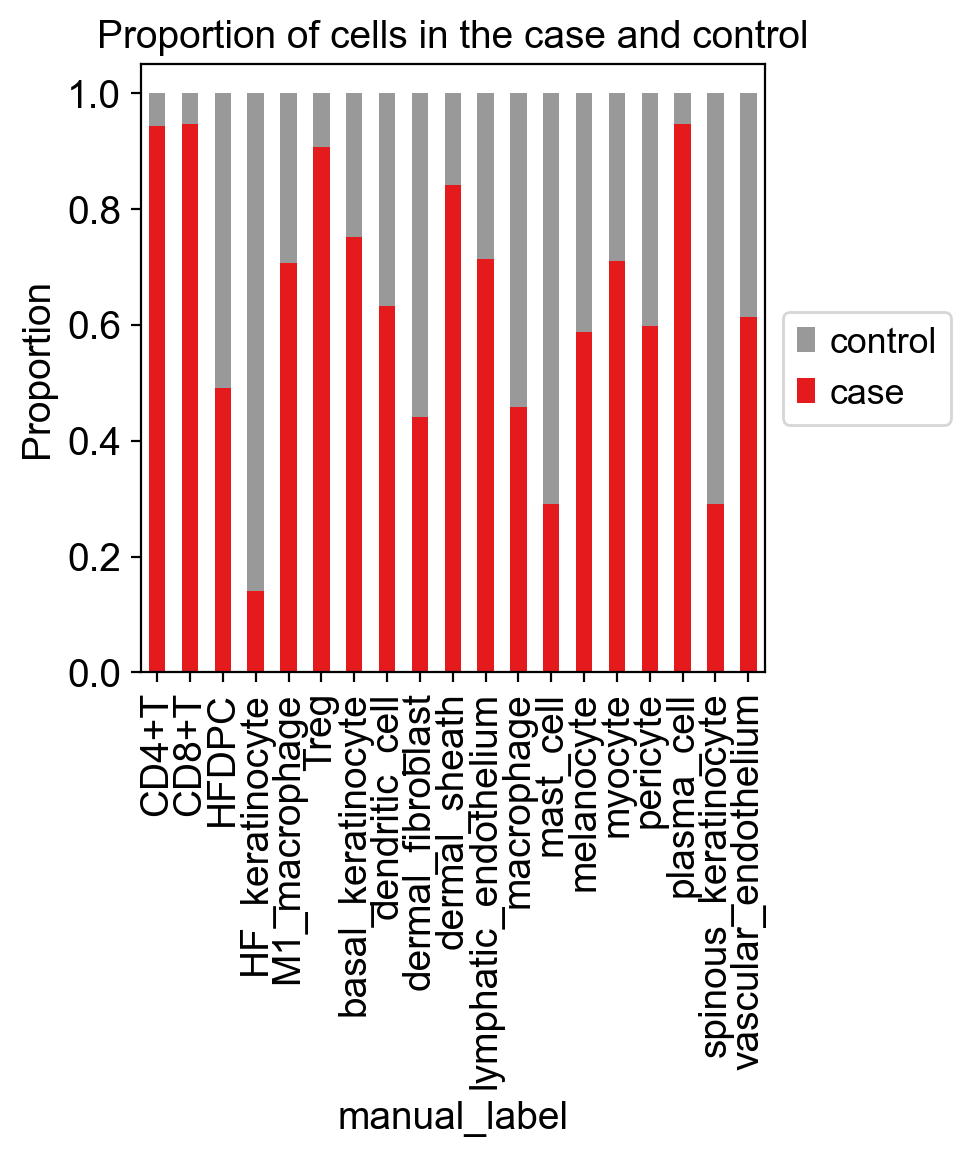

In [27]:
ax = df_grouped.plot(x= 'manual_label', kind='bar', stacked=True, colormap='Set1')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
plt.ylabel('Proportion')
plt.title('Proportion of cells in the case and control')
# Remove grid lines
ax.grid(False)
plt.show()

# 2. Compositional data analysis 

performing without pertpy

In [6]:
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

In [9]:
adata_case = adata[adata.obs['sample'] == 'case']

In [10]:
adata_control = adata[adata.obs['sample'] == 'control']

In [80]:
cov_df = pd.DataFrame({"hair": ["bold", "normal"]}, index=[1,2])

In [81]:
#data preparation
sccoda_data = dat.from_scanpy_list(
    [adata_case , adata_control],
    cell_type_identifier="manual_label",
    covariate_df = cov_df)
print(sccoda_data)

AnnData object with n_obs × n_vars = 2 × 19
    obs: 'hair'
    var: 'n_cells'


In [82]:
sccoda_data.obs

,hair
1,bold
2,normal


In [83]:
sccoda_data.var_names

Index(['CD4+T', 'CD8+T', 'Treg', 'dermal_fibroblast', 'myocyte',
       'vascular_endothelium', 'macrophage', 'dendritic_cell', 'dermal_sheath',
       'spinous_keratinocyte', 'basal_keratinocyte', 'mast_cell', 'melanocyte',
       'pericyte', 'plasma_cell', 'HFDPC', 'lymphatic_endothelium',
       'M1_macrophage', 'HF_keratinocyte'],
      dtype='object', name='manual_label')

In [84]:
sccoda_data.X

array([[1821,  751,  391,  332,  261,  196,  164,  145,  127,  116,  115,
          75,   70,   58,   54,   52,   40,   29,   12],
       [ 108,   42,   40,  420,  106,  123,  194,   84,   24,  282,   38,
         183,   49,   39,    3,   54,   16,   12,   73]])

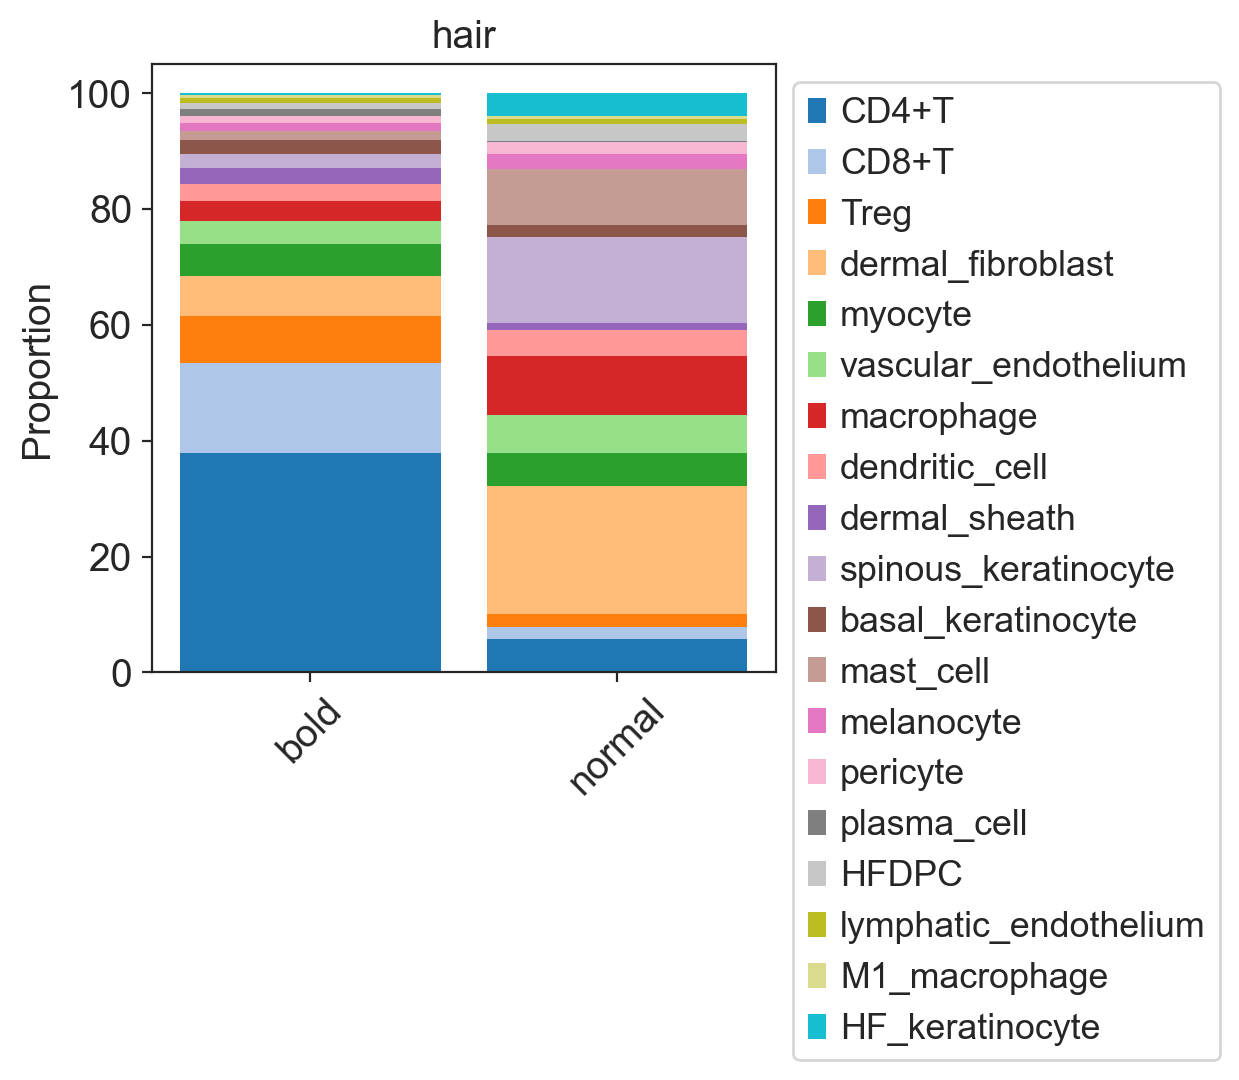

In [85]:
viz.stacked_barplot(sccoda_data, feature_name= "hair")
plt.show()

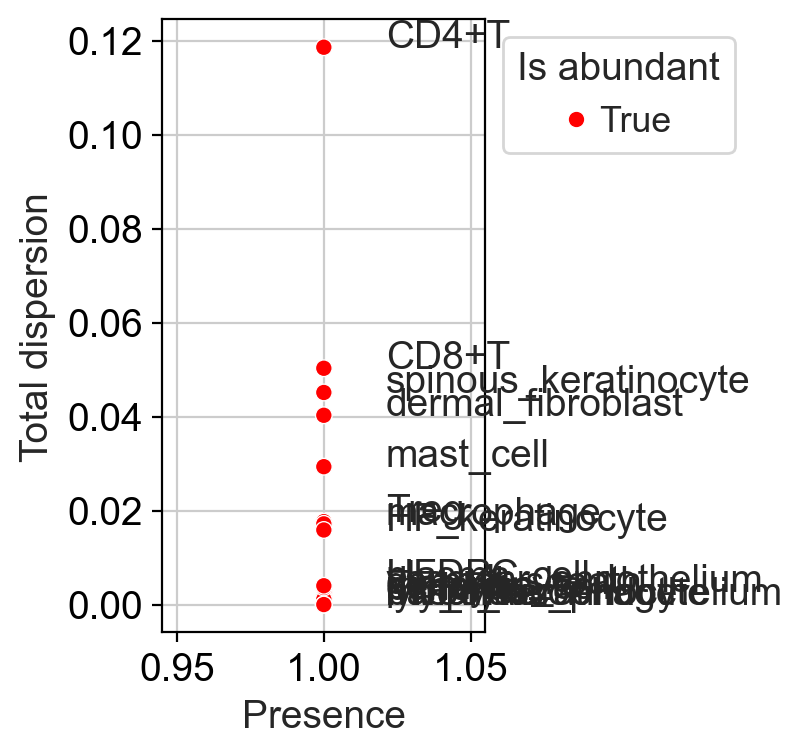

In [99]:
#Finding a reference cell type
#Cell types that have a higher presence than a certain threshold (default 0.9) are suitable candidates for the reference and thus colored.
viz.rel_abundance_dispersion_plot(
    data=sccoda_data,
    abundant_threshold=0.9
)
plt.show()

In [100]:
model = mod.CompositionalAnalysis(sccoda_data, formula="hair", reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to lymphatic_endothelium


In [101]:
# Run MCMC
sim_results = model.sample_hmc()

I0000 00:00:1723112660.577482  132131 service.cc:145] XLA service 0x6000023a0d00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723112660.579084  132131 service.cc:153]   StreamExecutor device (0): Host, Default Version
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:15<00:00, 264.42it/s]


MCMC sampling finished. (99.023 sec)
Acceptance rate: 53.8%


In [102]:
sim_results.summary()

Compositional Analysis summary:

Data: 2 samples, 19 cell types
Reference index: 16
Formula: hair

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
CD4+T                            4.449      1285.549002
CD8+T                            3.522       508.742068
Treg                             2.798       246.642802
dermal_fibroblast                2.823       252.886594
myocyte                          2.390       164.012254
vascular_endothelium             2.255       143.300116
macrophage                       2.165       130.966445
dendritic_cell                   1.880        98.488633
dermal_sheath                    1.469        65.296677
spinous_keratinocyte             1.832        93.872844
basal_keratinocyte               1.488        66.549175
mast_cell                        1.467        65.166214
melanocyte                       1.256        52.769910
pericyte                         1.037        42.

In [103]:
print(sim_results.credible_effects())

Covariate       Cell Type            
hair[T.normal]  CD4+T                     True
                CD8+T                     True
                Treg                      True
                dermal_fibroblast        False
                myocyte                  False
                vascular_endothelium     False
                macrophage               False
                dendritic_cell           False
                dermal_sheath            False
                spinous_keratinocyte      True
                basal_keratinocyte       False
                mast_cell                False
                melanocyte               False
                pericyte                 False
                plasma_cell              False
                HFDPC                    False
                lymphatic_endothelium    False
                M1_macrophage            False
                HF_keratinocyte          False
Name: Final Parameter, dtype: bool


performing with pertpy and save the result in MuData

In [8]:
import pertpy as pt
import mudata as mu

In [12]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="manual_label",
    sample_identifier="sample",
    covariate_obs=["sample"],
)
sccoda_data

MuData object with n_obs × n_vars = 6701 × 33557
  2 modalities
    rna:	6699 x 33538
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label', 'scCODA_sample_id'
      uns:	'_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap'
      obsm:	'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
      layers:	'counts', 'log1p_norm'
      obsp:	'connectivities', 'distances'
    coda:	2 x 19
      obs:	'sample'
      var:	'n_cells'

In [14]:
sccoda_data.mod['coda'].obs

,sample
scCODA_sample_id,
case,case
control,control


In [15]:
sccoda_data.mod['coda'].var_names

Index(['CD4+T', 'CD8+T', 'HFDPC', 'HF_keratinocyte', 'M1_macrophage', 'Treg',
       'basal_keratinocyte', 'dendritic_cell', 'dermal_fibroblast',
       'dermal_sheath', 'lymphatic_endothelium', 'macrophage', 'mast_cell',
       'melanocyte', 'myocyte', 'pericyte', 'plasma_cell',
       'spinous_keratinocyte', 'vascular_endothelium'],
      dtype='object', name='manual_label')

In [16]:
sccoda_data.mod['coda'].X

array([[1821,  751,   52,   12,   29,  391,  115,  145,  332,  127,   40,
         164,   75,   70,  261,   58,   54,  116,  196],
       [ 108,   42,   54,   73,   12,   40,   38,   84,  420,   24,   16,
         194,  183,   49,  106,   39,    3,  282,  123]])

<Axes: title={'center': 'sample'}, ylabel='Proportion'>

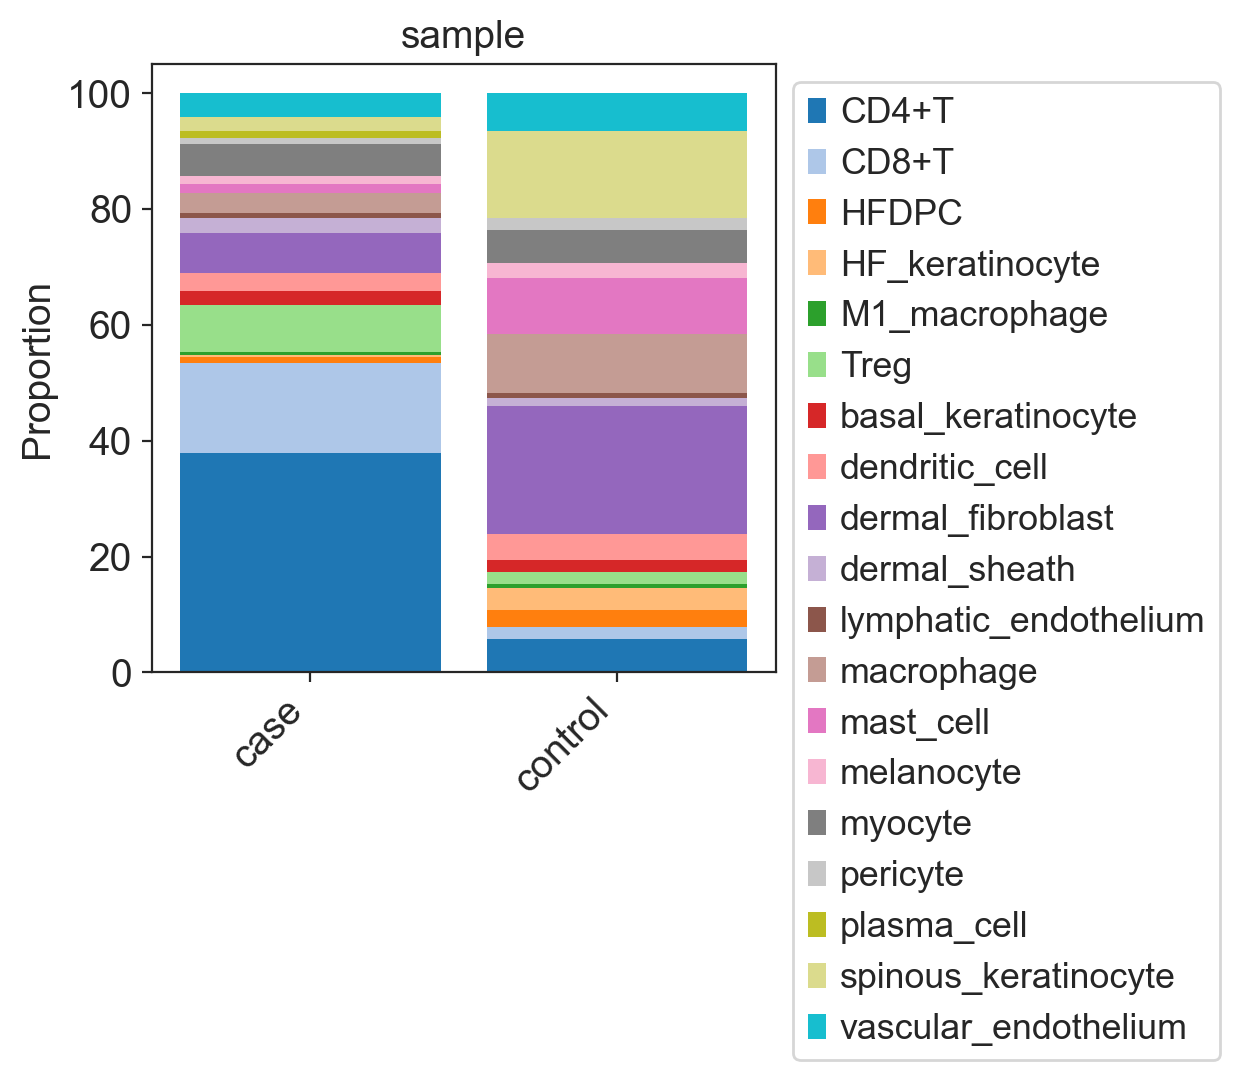

In [21]:
sccoda_model.plot_stacked_barplot(sccoda_data, feature_name="sample")

In [26]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="sample",
    reference_cell_type="automatic")

💡 Automatic reference selection! Reference cell type set to lymphatic_endothelium


In [27]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

sample: 100%|█████████████████████████████████████████████████████████████| 11000/11000 [00:33<00:00, 332.56it/s, 511 steps of size 1.46e-02. acc. prob=0.87]


In the case of scCODA, the desired acceptance rate is between 0.4 and 0.9.

In [29]:
sccoda_data.mod['coda']

AnnData object with n_obs × n_vars = 2 × 19
    obs: 'sample'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_sample[T.control]'

In [33]:
#calling result
#Intercepts show how the cell types are distributed without any active covariates, 
#effects show how the covariates influence the cell types.
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 2 samples, 19 cell types                                    │
│ Reference cell type                         │ lymphatic_endothelium                                             │
│ Formula                                     │ sample                                                            │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ CD4+T                      4.519           1277.581                                                             │
│ CD8+T                      3.593            506.095                                                             │
│ HFDPC                      1.173             45.003                                                             │
│ HF_keratinocyte            0.279             18.407                                                             │
│ M1_macrophage              0.356             19.880                                                             │
│ Treg                       2.885            249.317                                                             │
│ basal_keratinocyte         1.568             66.801                                                             │
│ dendritic_cell             1.993            102.179                                                             │
│ dermal_fibroblast          2.912            256.140                                                             │
│ dermal_sheath              1.558             66.137                                                             │
│ lymphatic_endothelium      0.642             26.462                                                             │
│ macrophage                 2.243            131.200                                                             │
│ mast_cell                  1.535             64.633                                                             │
│ melanocyte                 1.328             52.548                                                             │
│ myocyte                    2.473            165.128                                                             │
│ pericyte                   1.130             43.109                                                             │
│ plasma_cell                0.466             22.192                                                             │
│ spinous_keratinocyte       1.911             94.134                                                             │
│ vascular_endothelium       2.326            142.554                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                        Final Parameter  Expected Sample  log2-fold change                       │
│ Covariate       Cell Type                                                                                       │
│ sampleT.control CD4+T                      -2.157          267.961            -2.253                            │
│                 CD8+T                      -2.072          115.614            -2.130                            │
│                 HFDPC                       0.000           81.624             0.859                            │
│                 HF_keratinocyte             0.000           33.386             0.859                            │
│                 M1_macrophage               0.000           36.058             0.859                            │
│                 Treg                       -1.508          100.062            -1.317                            │
│                 basal_keratinocyte          0.000          121.161             0.859                            │
│                 dendritic_cell              0.000          185.327             0.859                            │
│                 dermal_fibroblast           0.000          464.575             0.859                            │
│                 dermal_sheath               0.000          119.956             0.859                            │
│                 lymphatic_endothelium       0.000           47.996             0.859                            │
│                 macrophage                  0.000          237.965             0.859                            │
│                 mast_cell                   0.000          117.228             0.859                            │
│                 melanocyte                  0.000           95.309             0.859                            │
│                 myocyte                     0.000          299.503             0.859                            │
│                 pericyte                    0.000           78.189             0.859                            │
│                 plasma_cell                 0.000           40.251             0.859                            │
│                 spinous_keratinocyte        1.335          648.776             2.785                            │
│                 vascular_endothelium        0.000          258.559             0.859                            │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [34]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate          Cell Type            
sample[T.control]  CD4+T                     True
                   CD8+T                     True
                   HFDPC                    False
                   HF_keratinocyte          False
                   M1_macrophage            False
                   Treg                      True
                   basal_keratinocyte       False
                   dendritic_cell           False
                   dermal_fibroblast        False
                   dermal_sheath            False
                   lymphatic_endothelium    False
                   macrophage               False
                   mast_cell                False
                   melanocyte               False
                   myocyte                  False
                   pericyte                 False
                   plasma_cell              False
                   spinous_keratinocyte      True
                   vascular_endothelium     False
Name: Fin

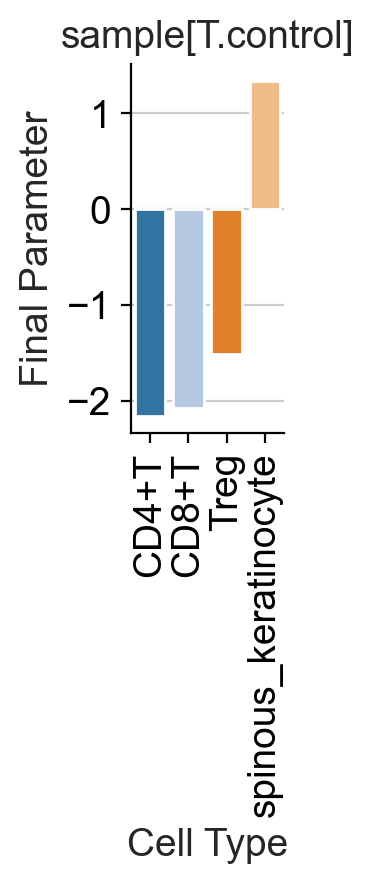

In [37]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda", parameter="Final Parameter")

**Interpretation:** In the control, there is an credible decrease of CD4+T, CD8+T, Treg and an credible increase of spinous_keratinocyte, while other cells are uneffected by the diseases. The log-fold change of CD4+T, CD8+T, Treg, and spinous keratinocyte between control and case with the same total cell count lies at about -2.253, -2.130, -1.317, 2.785.

The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR). A smaller FDR value will produce more conservative results, but might miss some effects, while a larger FDR value selects more effects at the cost of a larger number of false discoveries.

In [38]:
#Per default, the value is 0.05., => less strict FDR =0.2
sccoda_model.set_fdr(sccoda_data, 0.2)

In [39]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate          Cell Type            
sample[T.control]  CD4+T                     True
                   CD8+T                     True
                   HFDPC                    False
                   HF_keratinocyte           True
                   M1_macrophage            False
                   Treg                      True
                   basal_keratinocyte       False
                   dendritic_cell           False
                   dermal_fibroblast         True
                   dermal_sheath             True
                   lymphatic_endothelium    False
                   macrophage                True
                   mast_cell                 True
                   melanocyte               False
                   myocyte                  False
                   pericyte                 False
                   plasma_cell               True
                   spinous_keratinocyte      True
                   vascular_endothelium     False
Name: Fin

In [40]:
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 2 samples, 19 cell types                                    │
│ Reference cell type                         │ lymphatic_endothelium                                             │
│ Formula                                     │ sample                                                            │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ CD4+T                      4.519           1277.581                                                             │
│ CD8+T                      3.593            506.095                                                             │
│ HFDPC                      1.173             45.003                                                             │
│ HF_keratinocyte            0.279             18.407                                                             │
│ M1_macrophage              0.356             19.880                                                             │
│ Treg                       2.885            249.317                                                             │
│ basal_keratinocyte         1.568             66.801                                                             │
│ dendritic_cell             1.993            102.179                                                             │
│ dermal_fibroblast          2.912            256.140                                                             │
│ dermal_sheath              1.558             66.137                                                             │
│ lymphatic_endothelium      0.642             26.462                                                             │
│ macrophage                 2.243            131.200                                                             │
│ mast_cell                  1.535             64.633                                                             │
│ melanocyte                 1.328             52.548                                                             │
│ myocyte                    2.473            165.128                                                             │
│ pericyte                   1.130             43.109                                                             │
│ plasma_cell                0.466             22.192                                                             │
│ spinous_keratinocyte       1.911             94.134                                                             │
│ vascular_endothelium       2.326            142.554                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                        Final Parameter  Expected Sample  log2-fold change                       │
│ Covariate       Cell Type                                                                                       │
│ sampleT.control CD4+T                      -2.157          198.238            -2.688                            │
│                 CD8+T                      -2.072           85.531            -2.565                            │
│                 HFDPC                       0.000           60.386             0.424                            │
│                 HF_keratinocyte             1.488          109.339             2.570                            │
│                 M1_macrophage               0.000           26.676             0.424                            │
│                 Treg                       -1.508           74.026            -1.752                            │
│                 basal_keratinocyte          0.000           89.636             0.424                            │
│                 dendritic_cell              0.000          137.106             0.424                            │
│                 dermal_fibroblast           0.820          780.204             1.607                            │
│                 dermal_sheath              -0.791           40.216            -0.718                            │
│                 lymphatic_endothelium       0.000           35.508             0.424                            │
│                 macrophage                  0.730          365.171             1.477                            │
│                 mast_cell                   1.291          315.510             2.287                            │
│                 melanocyte                  0.000           70.510             0.424                            │
│                 myocyte                     0.000          221.573             0.424                            │
│                 pericyte                    0.000           57.844             0.424                            │
│                 plasma_cell                -1.016           10.780            -1.042                            │
│                 spinous_keratinocyte        1.335          479.966             2.350                            │
│                 vascular_endothelium        0.000          191.283             0.424                            │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

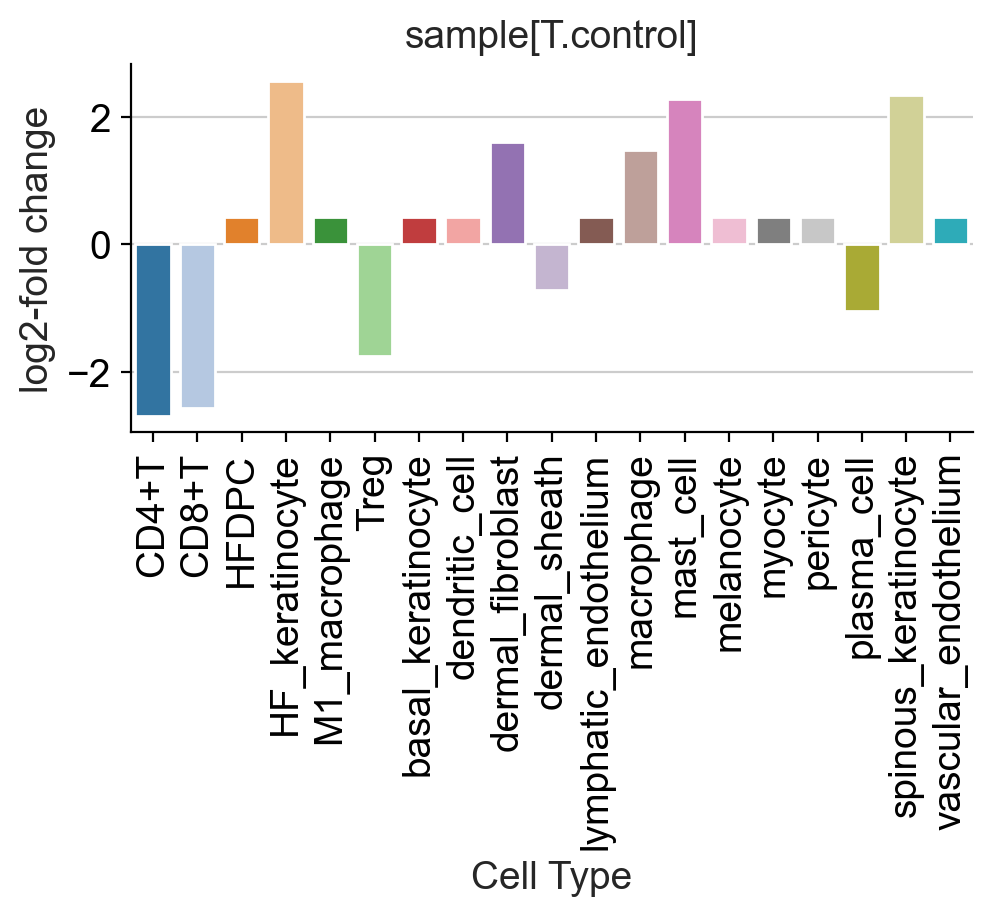

In [43]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda")

This result corresponds with the publication, which mentioned that 'samples from patients with alopecia areata had increased T lymphocytes and depletion of follicular keratinocytes.' These observations align with the pathophysiology of alopecia areata, which involves peribulbar hair follicle T-cell infiltration and disruption of normal hair follicle cycling.

**note** the cell count data is compositional and therefore an increase in the relative abundance of one cell type will lead to a decrease in the relative abundance of all other cell types. 
scCODA is used to statistically evaluate changes in abundance (to observe compositional changes)

In [61]:
#saving result
#sccoda_data.write_h5mu('sccoda_data')

In [62]:
#read
#sccoda_data = mu.read_h5mu('sccoda_data')

## 3. Differential gene expression analysis

#### 3.1. compare case and control using scvi

In [5]:
adata.raw = adata

In [6]:
adata

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [7]:
#use raw count matrix
scvi.data.poisson_gene_selection(adata, layer='counts')

Sampling from binomial...: 100%|█████████| 10000/10000 [00:19<00:00, 504.83it/s]


In [8]:
adata

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    var: 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [9]:
#subset to highly variable genes
adata = adata[:, adata.var.highly_variable].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 6699 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    var: 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [11]:
adata.raw.to_adata()

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [24]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="sample")

In [39]:
model = scvi.model.SCVI(adata)

In [45]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sample',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 6699  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 4000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    case    │          0          │
│                     │  control   │          1          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [46]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████████████████████████████████████████| 400/400 [30:41<00:00,  4.62s/it, v_num=1, train_loss_step=3.27e+3, train_loss_epoch=3.18e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████| 400/400 [30:41<00:00,  4.60s/it, v_num=1, train_loss_step=3.27e+3, train_loss_epoch=3.18e+3]


In [47]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [49]:
#get the scvi normalized expression
adata.layers['scVI_expr'] = model.get_normalized_expression(library_size = 1e4)

In [50]:
#save model 
model.save('model.model')

In [51]:
adata

AnnData object with n_obs × n_vars = 6699 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    var: 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm', 'scVI_expr'
    obsp: 'connectivities', 'distances'

In [58]:
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)

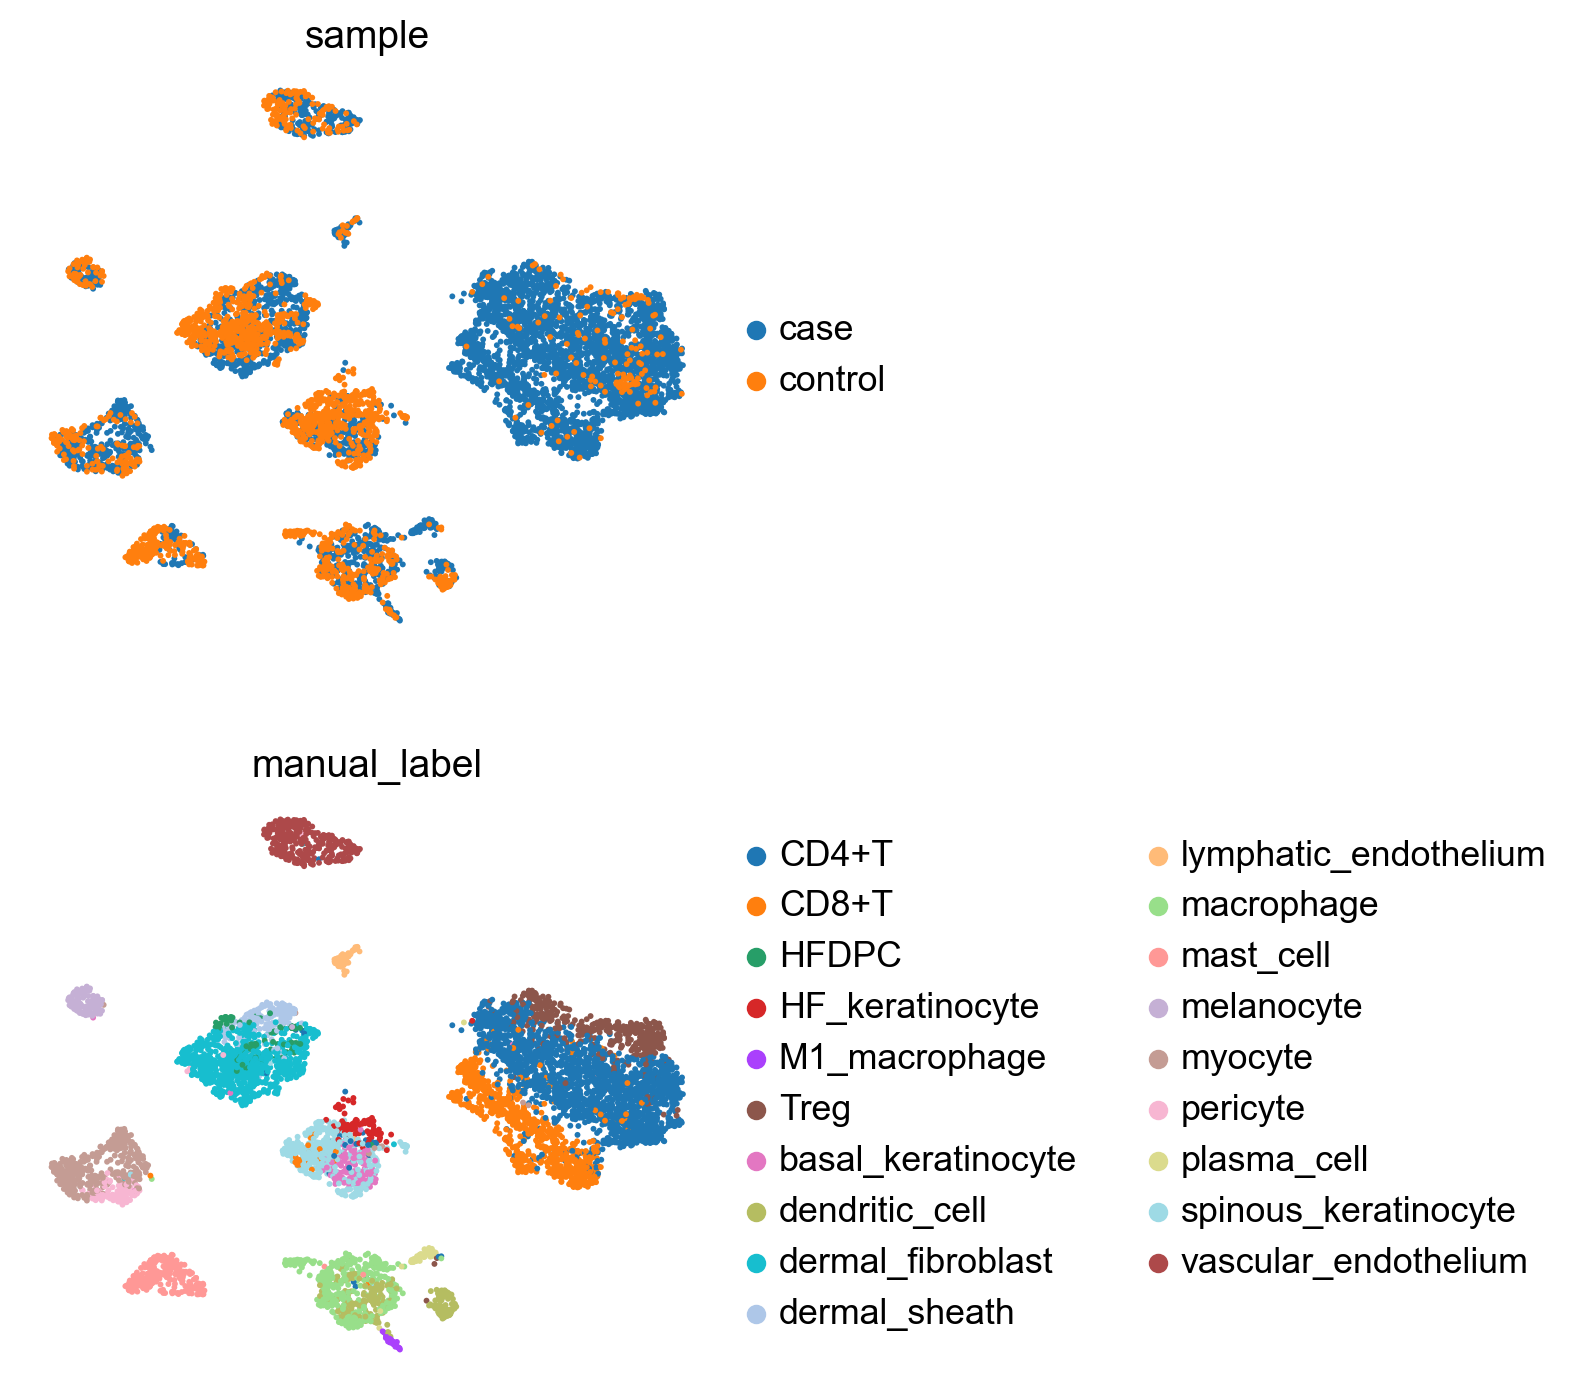

In [70]:
sc.pl.umap(adata, color=['sample', 'manual_label'], ncols =1)

**Comparation between CASE and CONTROL**

In [154]:
#reload trained model
model =  scvi.model.SCVI.load('model.model', adata = adata)

INFO     File model.model/model.pt already downloaded                                                              


In [155]:
#DE testing
scvi_DE_case_control = model.differential_expression(
            idx1 = [adata.obs['sample'] == 'case'],
            idx2 = [adata.obs['sample'] == 'control'])

DE...: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


In [156]:
scvi_DE_case_control

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
CHMP2A,1.0000,0.0000,18.420681,0.000917,0.000215,0.0,0.25,2.070804,2.075617,0.422875,0.580062,3.552700,0.463086,1.162435,0.282803,0.507937,1.606921,1.715510,True
UBE2M,1.0000,0.0000,18.420681,0.000686,0.000116,0.0,0.25,2.534847,2.536920,0.495843,0.791976,4.232250,0.448738,1.501058,0.288833,0.572487,1.659746,2.077651,True
NBDY,1.0000,0.0000,18.420681,0.000115,0.001537,0.0,0.25,-3.807158,-3.777356,0.800802,-6.381569,-1.072460,0.280100,0.650268,0.204200,0.387831,1.096926,1.202995,True
HMGA1,1.0000,0.0000,18.420681,0.000570,0.000104,0.0,0.25,2.419182,2.408534,0.554491,0.453571,4.372421,0.398833,2.447084,0.214598,0.481481,1.323908,2.828579,True
ARMCX3,1.0000,0.0000,18.420681,0.001921,0.000321,0.0,0.25,2.527475,2.519178,0.519824,0.765790,4.289872,0.575376,0.800534,0.349761,0.437566,2.790094,1.995238,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD2,0.3238,0.6762,-0.736363,0.000351,0.000324,0.0,0.25,0.118376,0.123598,0.219437,-0.682765,0.976096,1.607183,0.361376,0.484508,0.076190,11.616309,1.677741,False
H2AFZ,0.2902,0.7098,-0.894413,0.000789,0.000776,0.0,0.25,0.020455,0.017831,0.235854,-0.789771,0.854795,4.930694,14.472486,0.779580,0.904233,17.441723,22.057659,False
MGLL,0.2814,0.7186,-0.937528,0.000624,0.000599,0.0,0.25,0.058287,0.055001,0.230562,-0.776441,1.062154,0.223956,0.373545,0.116656,0.208466,0.634794,0.675180,False
RUNX3,0.2704,0.7296,-0.992594,0.000533,0.000557,0.0,0.25,-0.064995,-0.070686,0.214204,-0.840480,0.727587,0.794967,0.771430,0.369931,0.229101,5.039701,1.725909,False


In [157]:
#Volcano plot of change mode DE with p-value
# manipulate the DE results for plotting
scvi_DE_case_control["log10_pscore"] = np.log10(scvi_DE_case_control["proba_not_de"])
scvi_DE_case_control = scvi_DE_case_control.join(adata.var, how="inner")
scvi_DE_case_control.head()

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
CHMP2A,1.0,0.0,18.420681,0.000917,0.000215,0.0,0.25,2.070804,2.075617,0.422875,...,1.606921,1.715510,True,-inf,True,0.653680,0.589641,1,0.2747,32420.0
UBE2M,1.0,0.0,18.420681,0.000686,0.000116,0.0,0.25,2.534847,2.536920,0.495843,...,1.659746,2.077651,True,-inf,True,0.631139,0.557986,1,0.2839,32620.0
NBDY,1.0,0.0,18.420681,0.000115,0.001537,0.0,0.25,-3.807158,-3.777356,0.800802,...,1.096926,1.202995,True,-inf,True,0.743992,0.716527,1,0.2028,30666.0
HMGA1,1.0,0.0,18.420681,0.000570,0.000104,0.0,0.25,2.419182,2.408534,0.554491,...,1.323908,2.828579,True,-inf,True,0.710106,0.484888,1,0.3602,33220.0
ARMCX3,1.0,0.0,18.420681,0.001921,0.000321,0.0,0.25,2.527475,2.519178,0.519824,...,2.790094,1.995238,True,-inf,True,0.625466,0.598102,1,0.2512,31849.0


In [158]:
def label_gene(row):
    if (row['lfc_mean'] > 1.5) and (row['is_de_fdr_0.05'] == True):
        return 'UP'
    elif (row['lfc_mean'] < -1.5) and (row['is_de_fdr_0.05'] == True):
        return 'DOWN'
    else:
        return 'NOdiff'

In [159]:
# Apply the function to each row in the dataframe
scvi_DE_case_control['diff_expr'] = scvi_DE_case_control.apply(label_gene, axis=1)

In [160]:
# Filter out rows where log10_pscore is -inf
scvi_DE_case_control_plot = scvi_DE_case_control[scvi_DE_case_control["log10_pscore"] != -np.inf]
scvi_DE_case_control_plot

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank,diff_expr
MAGT1,0.9990,0.0010,6.906745,0.000398,0.001114,0.0,0.25,-1.473643,-1.485691,0.390069,...,1.003128,True,-3.000000,True,0.762651,0.736949,1,0.1935,30431.0,NOdiff
SNAPC1,0.9990,0.0010,6.906745,0.000327,0.000113,0.0,0.25,1.542993,1.556007,0.390568,...,1.114006,True,-3.000000,True,0.826243,0.748826,1,0.2093,30820.0,UP
CHMP3,0.9980,0.0020,6.212601,0.000389,0.000053,0.0,0.25,2.966733,2.956895,0.924618,...,1.133584,True,-2.698970,True,0.747126,0.719628,1,0.2126,30893.0,UP
FMNL1,0.9976,0.0024,6.029880,0.000281,0.000125,0.0,0.25,1.182814,1.192068,0.317147,...,0.854591,True,-2.619789,True,0.705478,0.666549,1,0.2364,31461.0,NOdiff
ZNF207,0.9968,0.0032,5.741396,0.000887,0.000132,0.0,0.25,2.666876,2.677157,0.921270,...,3.602495,True,-2.494850,True,0.397970,0.366480,1,0.2591,32026.0,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD2,0.3238,0.6762,-0.736363,0.000351,0.000324,0.0,0.25,0.118376,0.123598,0.219437,...,1.677741,False,-0.169925,True,0.630691,0.415116,1,0.3680,33242.0,NOdiff
H2AFZ,0.2902,0.7098,-0.894413,0.000789,0.000776,0.0,0.25,0.020455,0.017831,0.235854,...,22.057659,False,-0.148864,True,0.185252,0.045224,1,0.1750,29905.0,NOdiff
MGLL,0.2814,0.7186,-0.937528,0.000624,0.000599,0.0,0.25,0.058287,0.055001,0.230562,...,0.675180,False,-0.143513,True,0.857441,0.786597,1,0.1808,30058.0,NOdiff
RUNX3,0.2704,0.7296,-0.992594,0.000533,0.000557,0.0,0.25,-0.064995,-0.070686,0.214204,...,1.725909,False,-0.136915,True,0.669801,0.543177,1,0.2987,32832.0,NOdiff


In [161]:
#create new column column
scvi_DE_case_control_plot['delabel'] = ''

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_2392/1777825645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [162]:
#The values in the gene_symbol column are assigned to delabel for the rows where diffexpressed is not "NOdiff".
scvi_DE_case_control_plot.loc[scvi_DE_case_control_plot['diff_expr'] != 'NOdiff', 'delabel'] = scvi_DE_case_control_plot.index[scvi_DE_case_control_plot['diff_expr'] != 'NOdiff']

In [163]:
scvi_DE_case_control_plot

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,is_de_fdr_0.05,log10_pscore,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank,diff_expr,delabel
MAGT1,0.9990,0.0010,6.906745,0.000398,0.001114,0.0,0.25,-1.473643,-1.485691,0.390069,...,True,-3.000000,True,0.762651,0.736949,1,0.1935,30431.0,NOdiff,
SNAPC1,0.9990,0.0010,6.906745,0.000327,0.000113,0.0,0.25,1.542993,1.556007,0.390568,...,True,-3.000000,True,0.826243,0.748826,1,0.2093,30820.0,UP,SNAPC1
CHMP3,0.9980,0.0020,6.212601,0.000389,0.000053,0.0,0.25,2.966733,2.956895,0.924618,...,True,-2.698970,True,0.747126,0.719628,1,0.2126,30893.0,UP,CHMP3
FMNL1,0.9976,0.0024,6.029880,0.000281,0.000125,0.0,0.25,1.182814,1.192068,0.317147,...,True,-2.619789,True,0.705478,0.666549,1,0.2364,31461.0,NOdiff,
ZNF207,0.9968,0.0032,5.741396,0.000887,0.000132,0.0,0.25,2.666876,2.677157,0.921270,...,True,-2.494850,True,0.397970,0.366480,1,0.2591,32026.0,UP,ZNF207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD2,0.3238,0.6762,-0.736363,0.000351,0.000324,0.0,0.25,0.118376,0.123598,0.219437,...,False,-0.169925,True,0.630691,0.415116,1,0.3680,33242.0,NOdiff,
H2AFZ,0.2902,0.7098,-0.894413,0.000789,0.000776,0.0,0.25,0.020455,0.017831,0.235854,...,False,-0.148864,True,0.185252,0.045224,1,0.1750,29905.0,NOdiff,
MGLL,0.2814,0.7186,-0.937528,0.000624,0.000599,0.0,0.25,0.058287,0.055001,0.230562,...,False,-0.143513,True,0.857441,0.786597,1,0.1808,30058.0,NOdiff,
RUNX3,0.2704,0.7296,-0.992594,0.000533,0.000557,0.0,0.25,-0.064995,-0.070686,0.214204,...,False,-0.136915,True,0.669801,0.543177,1,0.2987,32832.0,NOdiff,


In [164]:
#plotnine is an implementation of a grammar of graphics in Python based on ggplot2
import plotnine as p9

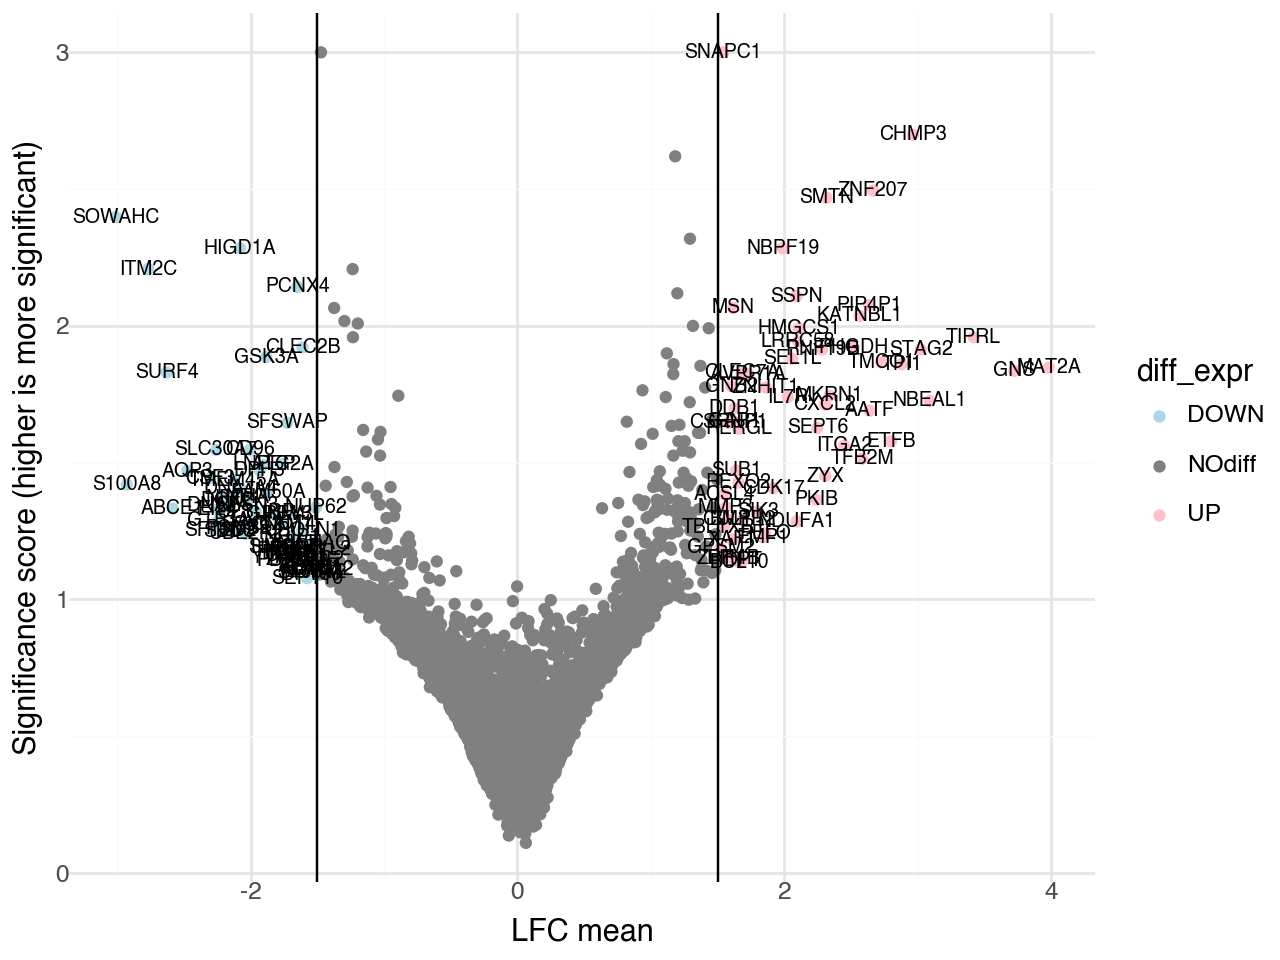

In [165]:
#use -log10 p-value
custom_colors = {"UP": "pink", "DOWN": "lightblue", "NOdiff": "gray"}
(
    p9.ggplot(scvi_DE_case_control_plot, p9.aes("lfc_mean", "-log10_pscore", color='diff_expr', label='delabel'))
    + p9.geom_point()
    + p9.geom_text(size=7, color='black')
    + p9.theme_minimal()
    + p9.scale_color_manual(values=custom_colors)
    + p9.geom_vline(xintercept = (-1.5, 1.5))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    #+ p9.geom_hline(yintercept = 0.05)
)

In [166]:
#create new column column
scvi_DE_case_control_plot['delabel_top20'] = ''

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_2392/864376419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [168]:
# Filter the DataFrame based on the 'diff_expr' condition
filtered_df = scvi_DE_case_control_plot[scvi_DE_case_control_plot['diff_expr'] != 'NOdiff']

# Sort the filtered DataFrame by 'log10_pscore' in descending order and select the top 20
top20_df = filtered_df.nsmallest(20, 'log10_pscore')

# Create a boolean mask for the top 20 entries
mask = scvi_DE_case_control_plot.index.isin(top20_df.index)

# Update 'delabel_top20' only for the top 20 entries
scvi_DE_case_control_plot.loc[mask, 'delabel_top20'] = scvi_DE_case_control_plot.index[mask]


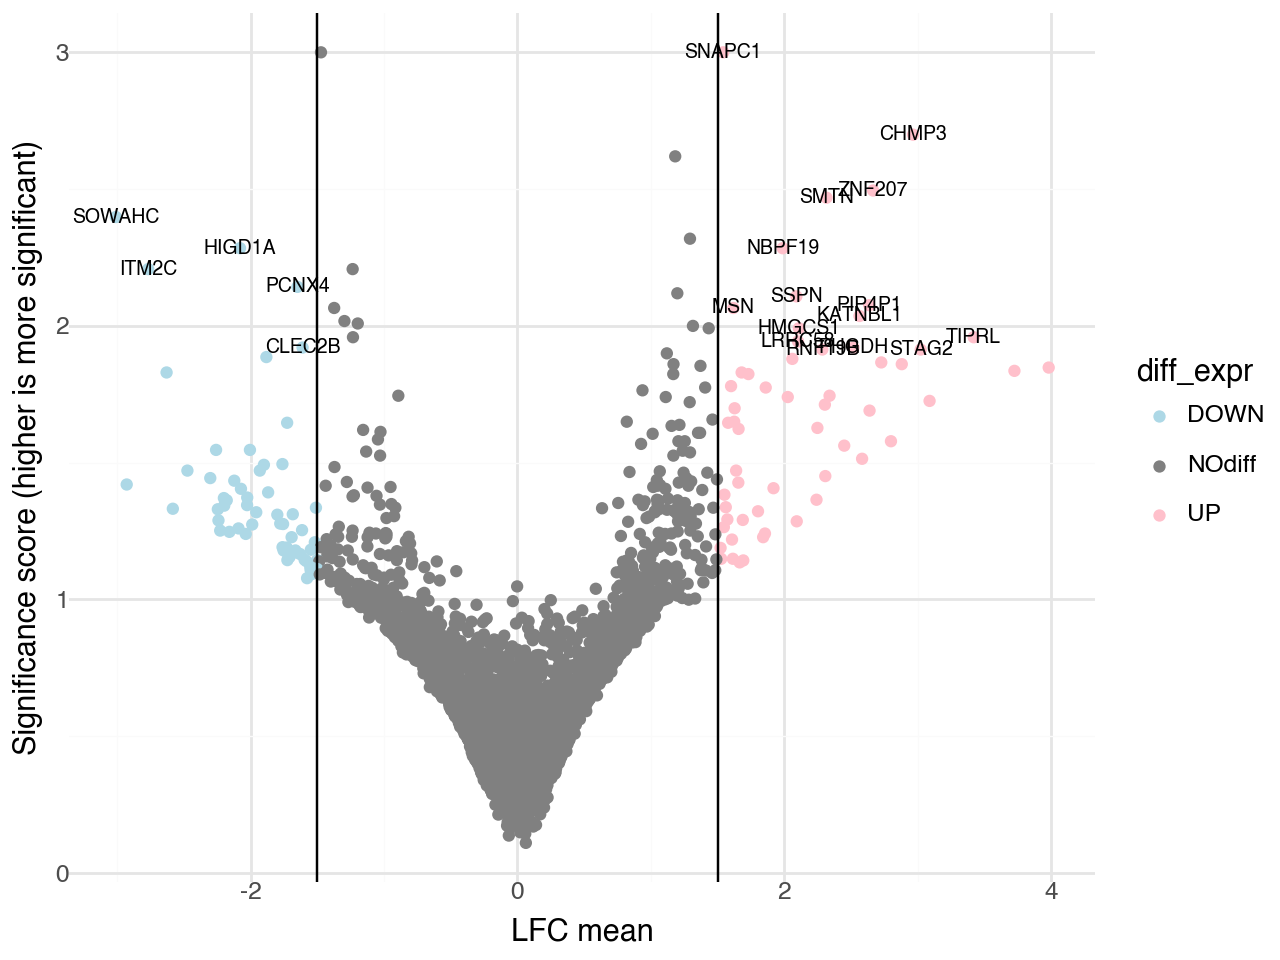

In [169]:
#use -log10 p-value
custom_colors = {"UP": "pink", "DOWN": "lightblue", "NOdiff": "gray"}
(
    p9.ggplot(scvi_DE_case_control_plot, p9.aes("lfc_mean", "-log10_pscore", color='diff_expr', label='delabel_top20'))
    + p9.geom_point()
    + p9.geom_text(size=7, color='black')
    + p9.theme_minimal()
    + p9.scale_color_manual(values=custom_colors)
    + p9.geom_vline(xintercept = (-1.5, 1.5))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    #+ p9.geom_hline(yintercept = 0.05)
)

In [149]:
scvi_DE_case_control = scvi_DE_case_control[(scvi_DE_case_control['is_de_fdr_0.05'] == True) & (abs(scvi_DE_case_control['lfc_mean']) > 1.5)]
scvi_DE_case_control = scvi_DE_case_control.sort_values('lfc_mean')
scvi_DE_case_control

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank,diff_expr
NBDY,1.0000,0.0000,18.420681,0.000116,0.001551,0.0,0.25,-3.812914,-3.778463,0.801707,...,1.202995,True,-inf,True,0.743992,0.716527,1,0.2028,30666.0,DOWN
SOWAHC,0.9970,0.0030,5.806135,0.000052,0.000410,0.0,0.25,-3.012543,-3.007501,1.033061,...,1.426006,True,-2.522879,True,0.830721,0.634302,1,0.2977,32822.0,DOWN
S100A8,0.9598,0.0402,3.172858,0.000007,0.000044,0.0,0.25,-2.856664,-2.863392,2.078195,...,8.442938,True,-1.395774,True,0.942678,0.171977,1,0.7858,33532.0,DOWN
ITM2C,0.9912,0.0088,4.724163,0.000047,0.000298,0.0,0.25,-2.755961,-2.744676,1.114568,...,0.801344,True,-2.055517,True,0.841618,0.806844,1,0.1633,29545.0,DOWN
SURF4,0.9840,0.0160,4.119037,0.000390,0.002139,0.0,0.25,-2.593161,-2.606989,1.204437,...,1.860468,True,-1.795880,True,0.646813,0.622529,1,0.2402,31569.0,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STAG2,0.9924,0.0076,4.871977,0.000249,0.000032,0.0,0.25,3.043395,3.006892,1.293540,...,2.488102,True,-2.119186,True,0.538886,0.517899,1,0.2629,32129.0,UP
NBEAL1,0.9848,0.0152,4.171142,0.000165,0.000022,0.0,0.25,3.084250,3.071012,1.451361,...,1.490362,True,-1.818156,True,0.705180,0.654217,1,0.2566,31970.0,UP
TIPRL,0.9882,0.0118,4.427785,0.000253,0.000025,0.0,0.25,3.406947,3.400037,1.614188,...,0.825847,True,-1.928118,True,0.781311,0.758882,1,0.1898,30318.0,UP
GNS,0.9872,0.0128,4.345427,0.000147,0.000012,0.0,0.25,3.748047,3.749662,1.856459,...,1.197424,True,-1.892790,True,0.842365,0.781441,1,0.1834,30125.0,UP


In [85]:
#get top 25 and bottom 25 genes
genes_to_show = scvi_DE_case_control[-25:].index.tolist() + scvi_DE_case_control[:25].index.tolist()

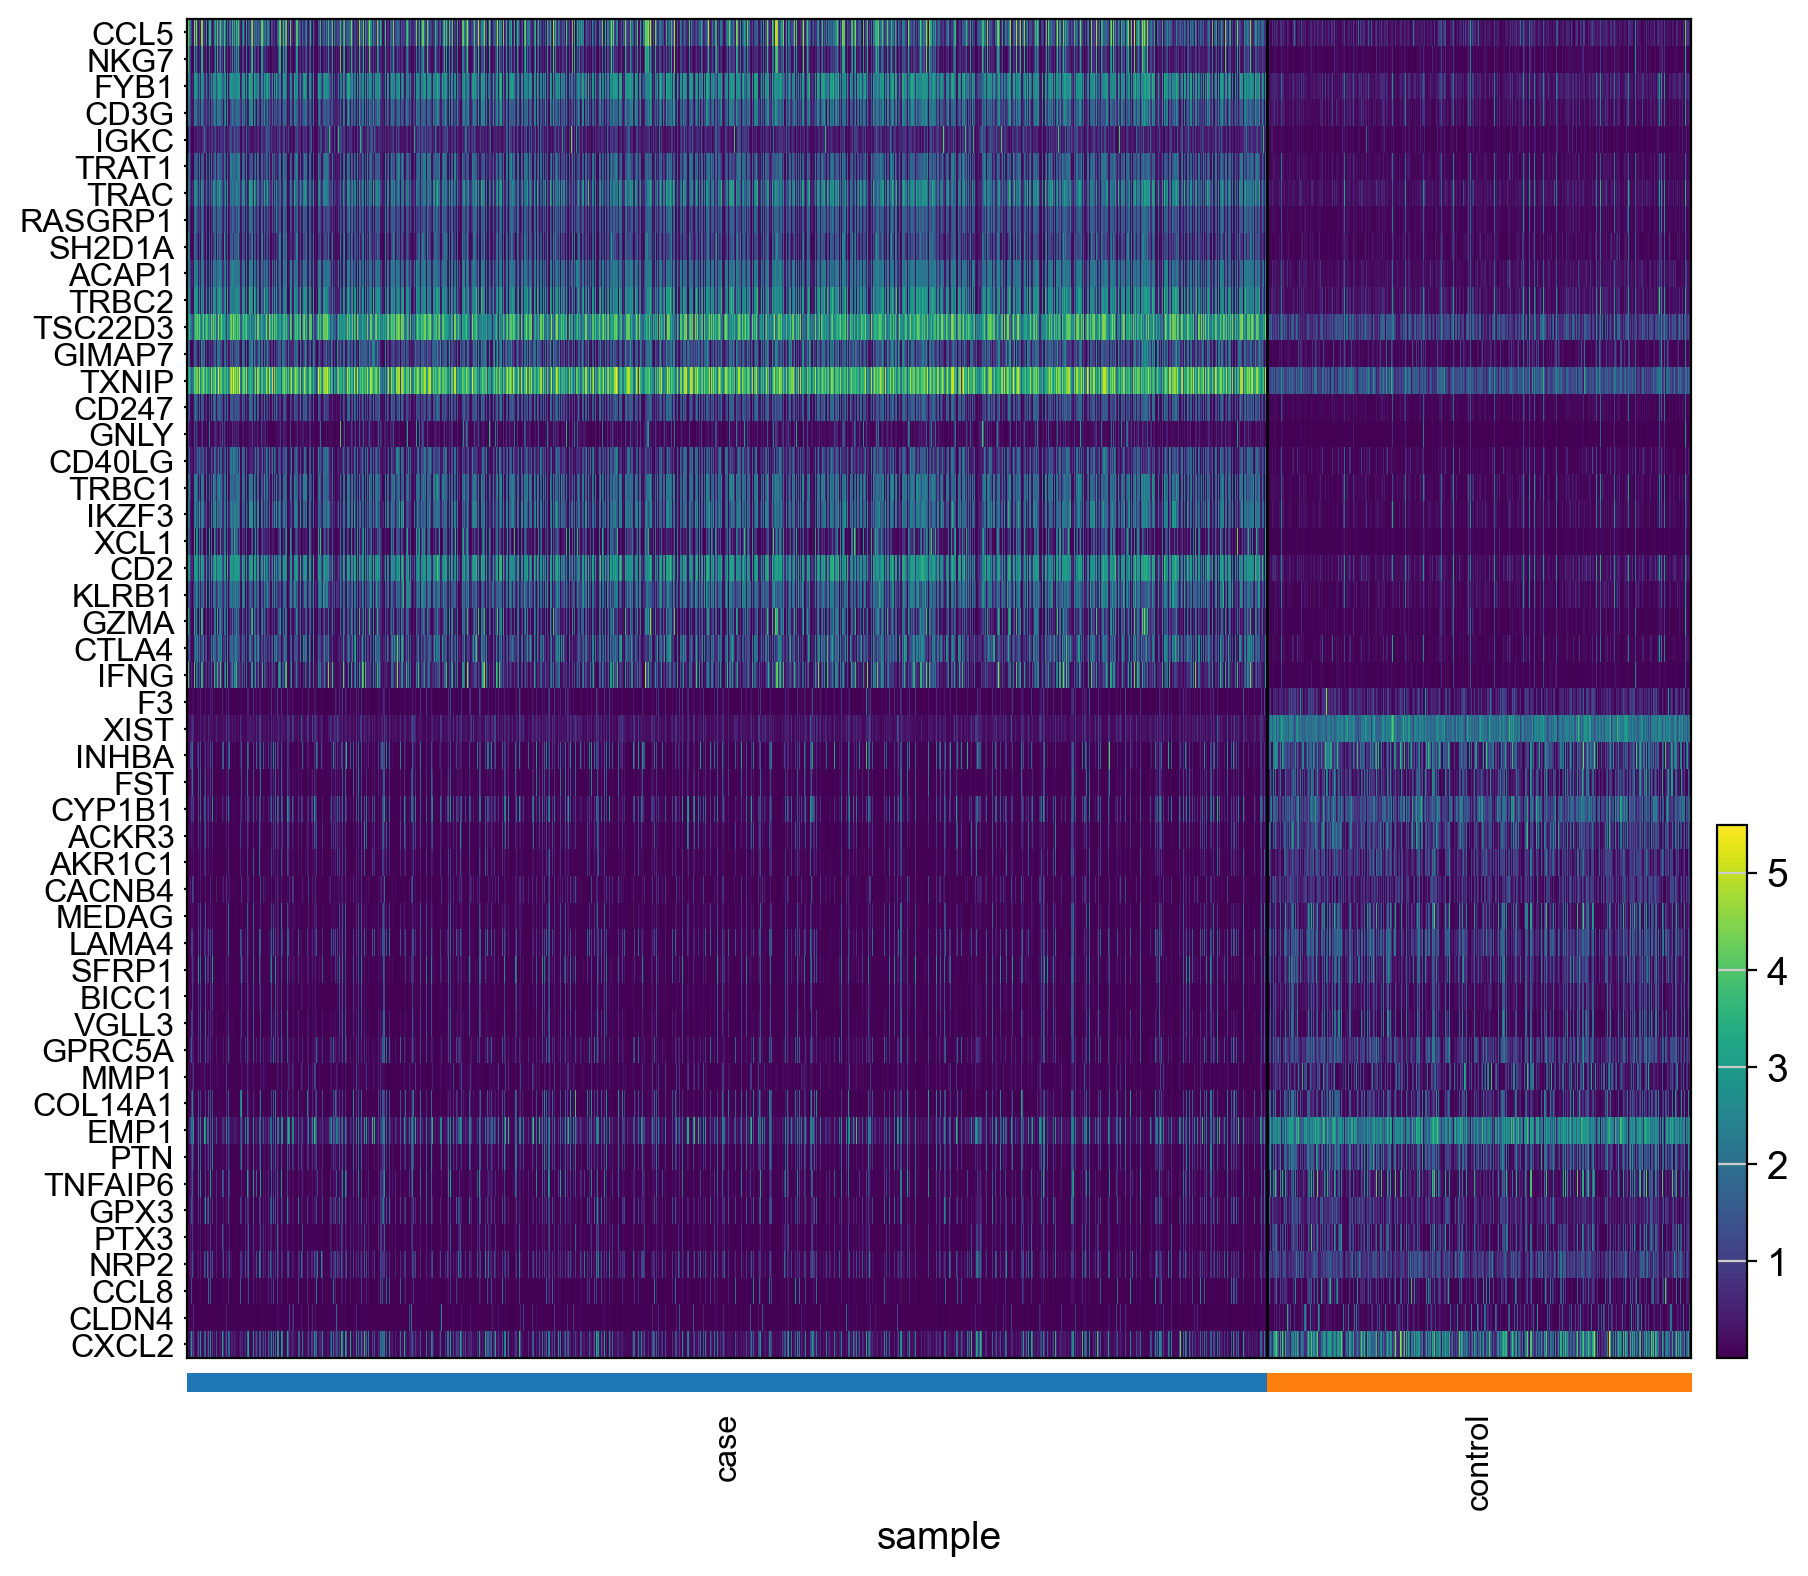

In [86]:
#plot the heat map differential expression between case vs control
sc.pl.heatmap(adata, genes_to_show, groupby='sample', swap_axes=True, layer='scVI_expr',\
             log=True)

**Comparation between T cell (CD4, CD8, Treg) of CASE and CONTROL***

In [98]:
subset_Tcell = adata[(adata.obs['manual_label'] == 'CD8+T') | (adata.obs['manual_label'] == 'CD4+T') | 
                (adata.obs['manual_label'] == 'Treg').copy()]

#### 3.2. compare case and control using edgeR